In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline

In [2]:
class DataDistribution(object):
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma

    def sample(self, N):
        samples = np.random.normal(self.mu, self.sigma, N)
        samples.sort()
        return samples

In [3]:
class GeneratorDistribution(object):
    def __init__(self, range):
        self.range = range

    def sample(self, N):
        return np.linspace(-self.range, self.range, N) + np.random.random(N) * 0.01

In [4]:
# G(z)
def generator(x, n_hidden=32):

    # initializers
    w_init = tf.truncated_normal_initializer(stddev=2)
    b_init = tf.constant_initializer(0.)

    # 1st hidden layer
    w0 = tf.get_variable('w0', [x.get_shape()[1], n_hidden], initializer=w_init)
    b0 = tf.get_variable('b0', [n_hidden], initializer=b_init)
    h0 = tf.nn.relu(tf.matmul(x, w0) + b0)

    # output layer
    w1 = tf.get_variable('w1', [h0.get_shape()[1], 1], initializer=w_init)
    b1 = tf.get_variable('b1', [1], initializer=b_init)
    o = tf.matmul(h0, w1) + b1

    return o

In [5]:
# D(x)
def discriminator(x, n_hidden=32):

    # initializers
    w_init = tf.contrib.layers.variance_scaling_initializer()
    b_init = tf.constant_initializer(0.)

    # 1st hidden layer
    w0 = tf.get_variable('w0', [x.get_shape()[1], n_hidden], initializer=w_init)
    b0 = tf.get_variable('b0', [n_hidden], initializer=b_init)
    h0 = tf.nn.relu(tf.matmul(x, w0) + b0)

    # output layer
    w1 = tf.get_variable('w1', [h0.get_shape()[1], 1], initializer=w_init)
    b1 = tf.get_variable('b1', [1], initializer=b_init)
    o = tf.sigmoid(tf.matmul(h0, w1) + b1)

    return o

In [6]:
# re-used for optimizing all networks
def optimizer(loss, var_list, num_decay_steps=400, initial_learning_rate=0.03):
    decay = 0.95
    batch = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(
        initial_learning_rate,
        batch,
        num_decay_steps,
        decay,
        staircase=True
    )
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(
        loss,
        global_step=batch,
        var_list=var_list
    )
    return optimizer

In [7]:
def plot_fig(D, x, G=None, z=None):
    # plots pg, pdata, decision boundary 
    f, ax = plt.subplots(1)
    # p_data
    xs = np.linspace(-5, 5, 1000)
    ax.plot(xs, norm.pdf(xs, loc=mu, scale=sigma), label='p_data')

    # decision boundary
    r = 5000 # resolution (number of points)
    xs = np.linspace(-5, 5, r)
    ds = np.zeros([r, 1]) # decision surface
    # process multiple points in parallel in same minibatch
    for i in range(r//M):
        x_ = np.reshape(xs[M*i:M*(i+1)], [M,1])
        ds[M*i:M*(i+1)] = sess.run(D, {x: x_})
    ax.plot(xs, ds, label='decision boundary')
    
    # distribution of inverse-mapped points
    if G is not None:
        zs = np.linspace(-5, 5, r)
        gs = np.zeros([r, 1]) # generator function
        for i in range(r//M):
            z_ = np.reshape(zs[M*i:M*(i+1)], [M,1])
            gs[M*i:M*(i+1)] = sess.run(G, {z: z_})
        histc, edges = np.histogram(gs, bins = 10)
        ax.plot(np.linspace(-5, 5, 10), histc/float(r), label='p_g')

    # ylim, legend
    ax.set_ylim(0,1.1)
    plt.legend()

# Pre-training session

In [8]:
# parameters
mu, sigma = 0, 1
data_range = 5
learning_rate = 0.03
n_initial_trainig_epochs = 1000
n_epochs = 3000
M = 150 # batch size

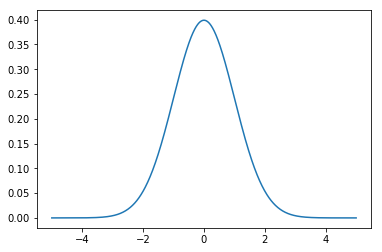

In [9]:
xs = np.linspace(-5, 5, 1000)
plt.plot(xs, norm.pdf(xs, loc=mu, scale=sigma))

In [10]:
data = DataDistribution(mu, sigma)
gen = GeneratorDistribution(data_range)

In [11]:
with tf.variable_scope('P'):
    input_node = tf.placeholder(tf.float32, shape=[None, 1], name='inputs')
    train_labels = tf.placeholder(tf.float32, shape=[None, 1], name='targets')
    P = discriminator(input_node)
    P_loss = tf.reduce_mean(tf.square(P - train_labels))

P_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='P')
P_optimizer = optimizer(P_loss, P_params, num_decay_steps=400, initial_learning_rate=learning_rate)

In [12]:
# open session and initialize all variables
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

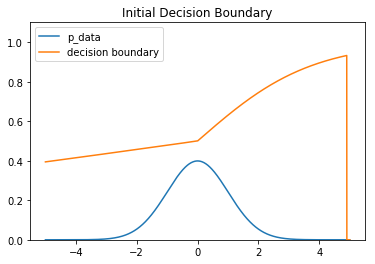

In [13]:
plot_fig(P, input_node)
plt.title('Initial Decision Boundary')

In [14]:
lh = np.zeros(n_initial_trainig_epochs)
for i in range(n_initial_trainig_epochs):
    
    N = 1000
    d = data.sample(N)
    n_bins = 100
    histc, edges = np.histogram(d, bins=n_bins, density=True)

    # Estimated pdf is used as labels after normalization
    max_histc = np.max(histc)
    min_histc = np.min(histc)
    labels = (histc - min_histc) / (max_histc - min_histc)
    d = edges[1:]
    
    x_ = np.reshape(d, [n_bins, 1])
    y_ = np.reshape(labels, [n_bins, 1])
    lh[i], _ = sess.run([P_loss, P_optimizer], {input_node: x_, train_labels: y_})

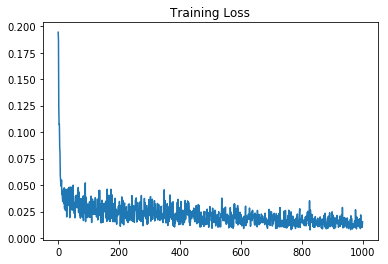

In [15]:
# training loss
plt.plot(lh)
plt.title('Training Loss')

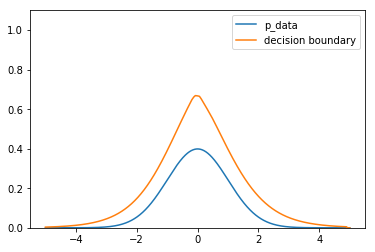

In [16]:
plot_fig(P, input_node)

In [17]:
# copy the learned weights over into a tmp array
P_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='P')
weights_P = sess.run(P_params)

In [18]:
sess.close()

# Build Net

In [19]:
with tf.variable_scope('G'):
    z = tf.placeholder(tf.float32, shape=[None, 1], name='inputs')
    G = generator(z)
    #G = tf.multiply(5.0, G) # scale up by 5 to match range

In [20]:
with tf.variable_scope('D') as scope:
    x = tf.placeholder(tf.float32, shape=[None, 1], name='inputs')
    D_real = discriminator(x)
    # clamp as a probability
    D_real = tf.maximum(tf.minimum(D_real, 0.99), 0.01)
    
    scope.reuse_variables()
    D_fake = discriminator(G)
    # clamp as a probability
    D_fake = tf.maximum(tf.minimum(D_fake, 0.99), 0.01)

In [21]:
# loss for each network
D_loss = tf.reduce_mean(-tf.log(D_real) - tf.log(1 - D_fake))
G_loss = tf.reduce_mean(-tf.log(D_fake))
#D_loss = tf.reduce_mean(tf.log(D_real) + tf.log(1 - D_fake))
#G_loss = tf.reduce_mean(tf.log(D_fake))

In [22]:
# trainable variables for each network
D_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='D')
G_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='G')

In [23]:
# optimizer for each network
D_optimizer = optimizer(D_loss, D_params, num_decay_steps=400, initial_learning_rate=learning_rate)
G_optimizer = optimizer(G_loss, G_params, num_decay_steps=400, initial_learning_rate=learning_rate)
#D_optimizer = optimizer(1-D_loss, D_params, learning_rate)
#G_optimizer = optimizer(1-G_loss, G_params, learning_rate)

In [24]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [25]:
# copy weights from pre-training over to new D network
for i, v in enumerate(D_params):
    sess.run(v.assign(weights_P[i]))

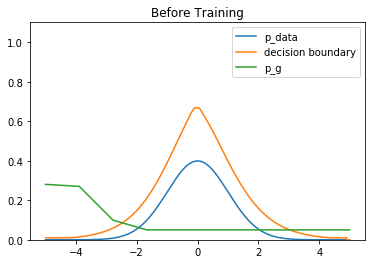

In [26]:
# initial conditions
plot_fig(D_real, x, G, z)
plt.title('Before Training')

In [27]:
# # Algorithm 1 of Goodfellow et al 2014
# print_step = n_epochs // 10
# histd, histg = np.zeros(n_epochs), np.zeros(n_epochs)
# for i in range(n_epochs):
#     x_ = np.random.normal(mu, sigma, M) # sampled m-batch from p_data
#     x_.sort()
#     x_ = np.reshape(x_, [M, 1])
#     z_ = np.linspace(-5.0, 5.0, M) + np.random.random(M) * 0.01  # sample m-batch from noise prior
#     z_ = np.reshape(z_, [M, 1])
#     histd[i], _ = sess.run([D_loss, D_optimizer], {x: x_, z: z_})
    
#     z_ = np.linspace(-5.0, 5.0, M) + np.random.random(M) * 0.01 # sample noise prior
#     z_ = np.reshape(z_, [M, 1])
#     histg[i], _ = sess.run([G_loss, G_optimizer], {z: z_}) # update generator
#     if i % print_step == 0:
#         print(float(i)/float(n_epochs))

# test2

print_step = n_epochs // 10
histd, histg = np.zeros(n_epochs), np.zeros(n_epochs)
for i in range(n_epochs):
    # 1. train D
    x_ = data.sample(M) # sampled m-batch from p_data
    x_ = np.reshape(x_, [M, 1])
    z_ = gen.sample(M)  # sample m-batch from noise prior
    z_ = np.reshape(z_, [M, 1])
    histd[i], _ = sess.run([D_loss, D_optimizer], {x: x_, z: z_})
    
    # 2. train G
    z_ = gen.sample(M)  # sample m-batch from noise prior
    z_ = np.reshape(z_, [M, 1])
    histg[i], _ = sess.run([G_loss, G_optimizer], {z: z_}) # update generator
    if i % print_step == 0:
        print(float(i)/float(n_epochs))

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


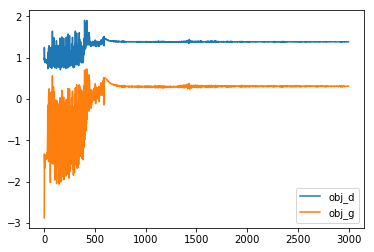

In [28]:
plt.plot(range(n_epochs), histd, label='obj_d')
plt.plot(range(n_epochs), 1-histg, label='obj_g')
plt.legend()

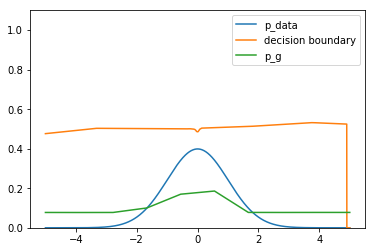

In [29]:
plot_fig(D_real, x, G, z)

In [30]:
sess.close()